# Srovnání SVD a randomizovaného SVD

Na provedení singulárního rozkladu (SVD) a randomizovaného singulárního rozkladu (randomized SVD) jsem se rozhodl využít třídu TruncatedSVD z knihovny scikit-learn, která implementuje naivní algoritmus (arpack) i randomizovaný algoritmus pro řídké matice, což umožňuje jednoduché porovnání obou algoritmů. Program pracuje s řídkými maticemi ve formátu CSR.

První je nutné naimportovat všechny potřebné záležitosti:

In [15]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random, load_npz
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import timeit, tracemalloc

Dále načteme matice, se kterými budeme pracovat. Jedná se o jednu náhodnou matici, na které si ukážeme různé typy měření, a dále o 5 různě strukturovaných matic vypůjčených ze SuiteSparse Matrix Collection pocházejících z různých problémů reálného světa. Všechny matice mají velikost přibližně 1000×1000.

In [29]:
demo_matrix = random(1000, 1000, 0.1, "csr", rng=13)  # náhodná matice na ukázku jednotlivých měření

# ukázkové matice z reálného světa
example_pwr1 = load_npz("mat/1138_bus.npz")     # Power Network Problem: čtvercová spd reálná
example_pwr2 = load_npz("mat/bcspwr06.npz")     # Power Network Problem: čtvercová symetrická binární
example_strc = load_npz("mat/bcsstk08.npz")     # Structural Problem: čtvercová spd reálná
example_chem = load_npz("mat/west1505.npz")     # Chemical Process Simulation Problem: čtvercová reálná
example_comb = load_npz("mat/TF13.npz")         # Combinatorial Problem: obdélníková celočíselná

Matice si můžeme zobrazit:

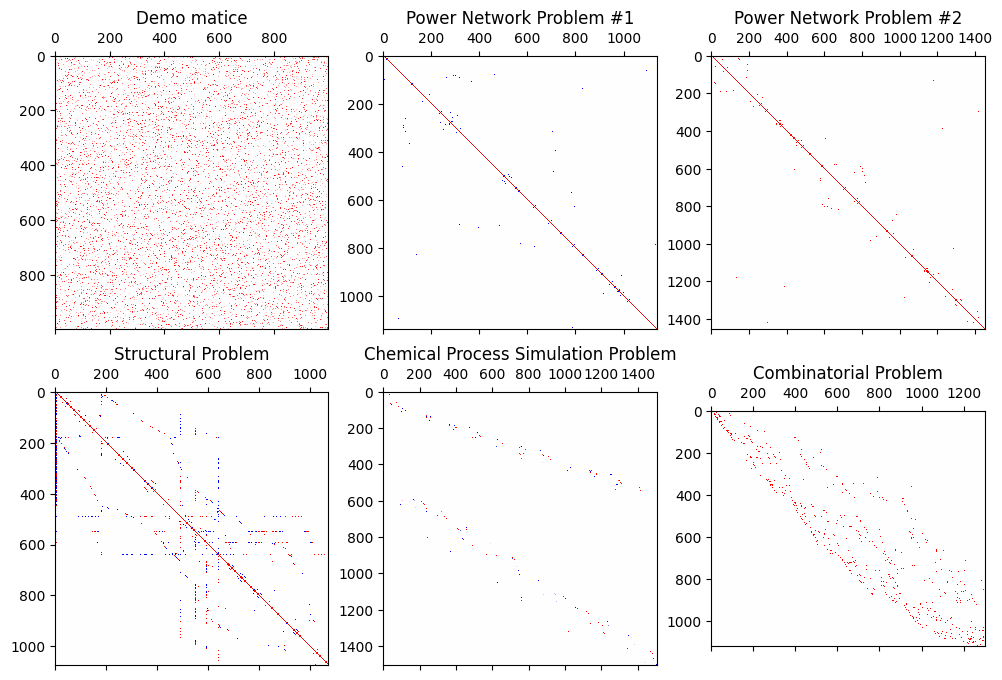

In [36]:
fig = plt.figure(figsize=(12, 8))
ax = fig.subplots(2, 3)

ax[0, 0].set_title("Demo matice")
ax[0, 1].set_title("Power Network Problem #1")
ax[0, 2].set_title("Power Network Problem #2")
ax[1, 0].set_title("Structural Problem")
ax[1, 1].set_title("Chemical Process Simulation Problem")
ax[1, 2].set_title("Combinatorial Problem")

norm = CenteredNorm()
colmap = "bwr"
ax[0, 0].matshow(demo_matrix.todense(), norm=norm, cmap=colmap)
ax[0, 1].matshow(example_pwr1.todense(), norm=norm, cmap=colmap)
ax[0, 2].matshow(example_pwr2.todense(), norm=norm, cmap=colmap)
ax[1, 0].matshow(example_strc.todense(), norm=norm, cmap=colmap)
ax[1, 1].matshow(example_chem.todense(), norm=norm, cmap=colmap)
ax[1, 2].matshow(example_comb.todense(), norm=norm, cmap=colmap)

## Měření rychlosti
Měření rychlosti je provedeno pro různé cílové hodnosti aproximované matice. Rozhodl jsem se k tomuto účelu použít funkci timeit ze stejnojmenného modulu, neboť provádí stejný příkaz vícekrát za účelem snížení možných náhodných fluktuací ve výsledku.

In [37]:
def measure_time(M, x):
    y_arp = []
    y_ran = []

    for k in x:
        svd = TruncatedSVD(n_components=k, algorithm="arpack")
        rsvd = TruncatedSVD(n_components=k, algorithm="randomized")
        y_arp.append(timeit.timeit(lambda: svd.fit(M), number=10))
        y_ran.append(timeit.timeit(lambda: rsvd.fit(M), number=10))
    
    return np.array(y_arp), np.array(y_ran)

Dále vytvoříme funkci na vykreslení získaných hodnot:

In [38]:
def show_graph(x, y_arp, y_ran, title, ylabel, ax=None):
    if ax == None:
        fig, ax = plt.subplots()
    
    ax.set_title(title)
    ax.set_xlabel("Hodnost aproximované matice")
    ax.set_ylabel(ylabel)
    ax.plot(x, y_arp, "g.-", label="Arpack")
    ax.plot(x, y_ran, "r.-", label="Randomized")
    ax.set_xticks(x)
    ax.legend()

Vyzkoušíme na matici:

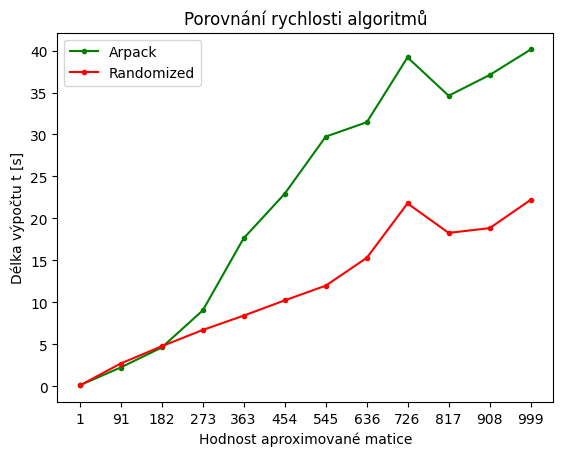

In [40]:
n_min = min(demo_matrix.shape)
x = np.linspace(1, n_min-1, 12, dtype=int)

y_arp_t, y_ran_t = measure_time(demo_matrix, x)
show_graph(x, y_arp_t, y_ran_t, "Porovnání rychlosti algoritmů", "Délka výpočtu t [s]")
plt.show()

## Měření paměti
Pro měření využití paměti jsem využil knihovnu tracemalloc, která měří množství alokované paměti za určitou dobu. Jako dříve je měření provedeno několikrát pro různé hodnosti matice.

In [41]:
def measure_memory(M, x):
    y_arp = np.zeros_like(x, dtype=float)
    y_ran = np.zeros_like(x, dtype=float)
    repeat_times = 3
    svds = []
    tracemalloc.start()

    for _ in range(repeat_times):
        for i, k in enumerate(x):
            mem_before, _ = tracemalloc.get_traced_memory()
            svds.append(TruncatedSVD(n_components=k, algorithm="arpack"))
            svds[-1].fit(M)
            mem_after, _ = tracemalloc.get_traced_memory()
            y_arp[i] += mem_after - mem_before

            mem_before, _ = tracemalloc.get_traced_memory()
            svds.append(TruncatedSVD(n_components=k, algorithm="randomized"))
            svds[-1].fit(M)
            mem_after, _ = tracemalloc.get_traced_memory()
            y_ran[i] += mem_after - mem_before
    
    y_arp /= repeat_times
    y_ran /= repeat_times
    tracemalloc.stop()
    
    return y_arp, y_ran

Vyzkoušíme na matici:

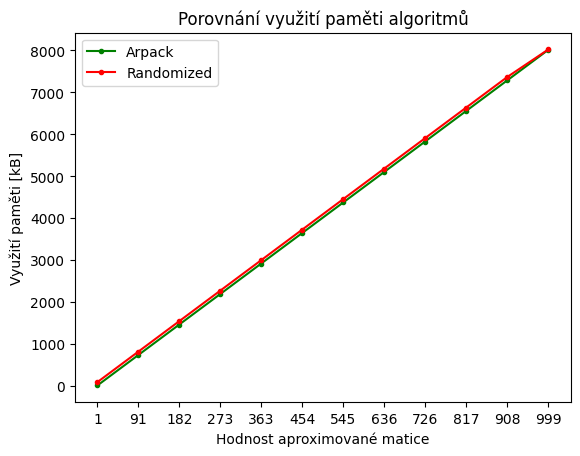

In [42]:
y_arp_m, y_ran_m = measure_memory(demo_matrix, x)
show_graph(x, y_arp_m/1000, y_ran_m/1000, "Porovnání využití paměti algoritmů", "Využití paměti [kB]")
plt.show()

## Měření přesnosti aproximace
Přesnost $p$ aproximované matice $\tilde{M}$ k původní matici $M$ určíme například podle jednoduchého vzorečku

$$
\begin{equation}
p = 1 - \frac{\| \tilde{M} - M \|}{\| M \|},
\end{equation}
$$

kde $\| \cdot \|$ označuje Frobeniovu normu matice. Přesnost náleží intervalu $\langle 0, 1 \rangle$. Čím přesnější je aproximace, tím více se $p$ blíží $100 \%$.

In [43]:
def measure_accuracy(M, x):
    y_arp = []
    y_ran = []
    M_dense = M.todense("C")
    norm_exact = np.linalg.norm(M_dense)
    
    for k in x:
        svd = TruncatedSVD(n_components=k, algorithm="arpack")
        M_transformed = svd.fit_transform(M)
        M_tilde = M_transformed @ svd.components_
        norm_diff = np.linalg.norm(M_tilde - M_dense)
        y_arp.append(1 - norm_diff / norm_exact)

        rsvd = TruncatedSVD(n_components=k, algorithm="randomized")
        M_transformed = rsvd.fit_transform(M)
        M_tilde = M_transformed @ rsvd.components_
        norm_diff = np.linalg.norm(M_tilde - M_dense)
        y_ran.append(1 - norm_diff / norm_exact)
    
    return np.array(y_arp), np.array(y_ran)

Vyzkoušíme na matici:

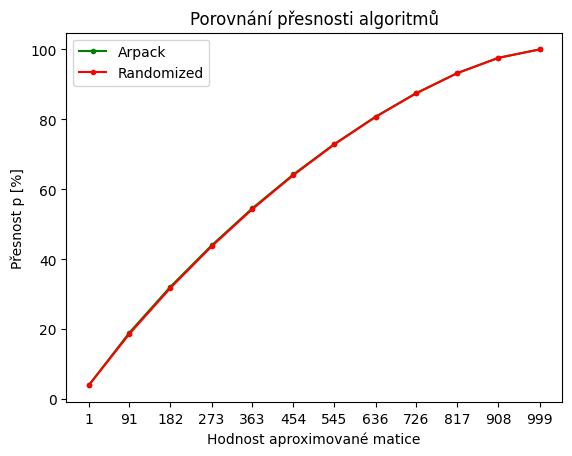

In [44]:
y_arp_a, y_ran_a = measure_accuracy(demo_matrix, x)
show_graph(x, 100*y_arp_a, 100*y_ran_a, "Porovnání přesnosti algoritmů", "Přesnost p [%]")
plt.show()

## Analýza kompromisu mezi přesností a rychlostí
Hledáme takovou hodnost aproximované matice, pro kterou dostaneme co největší přesnost $p$ za co nejkratší čas $t$, tedy hledáme nejvyšší poměr $p/t$.

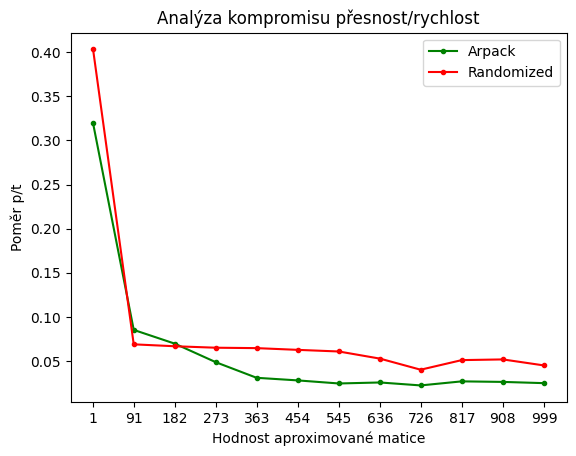

In [45]:
y_arp_k = y_arp_a / y_arp_t
y_ran_k = y_ran_a / y_ran_t
show_graph(x, y_arp_k, y_ran_k, "Analýza kompromisu přesnost/rychlost", "Poměr p/t")
plt.show()